## Классификация пород собак на основе EfficientNetV2

Используя Keras 3, необходимо произвести тонкую настройку модели [EfficientNetV2](https://keras.io/api/applications/efficientnet_v2/) на примере набора данных [Stanford Dogs](https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip).

In [ ]:
# Установка и обновление Keras до версии 3.0
!pip install --upgrade keras>=3.5.0 # Для фикса бага с numpy https://github.com/brainglobe/cellfinder/issues/446

3.9.2


## Импорт необходимых библиотек

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import data as tf_data
import os
import keras
from keras import layers
from keras.applications import EfficientNetV2B0  # Используем EfficientNetV2B0
import random
import shutil

## Подготовка констант и загрузка датасета

In [ ]:
# Определение констант
IMAGE_SIZE = (224, 224)  # Размер изображений, определенный моделью
BATCH_SIZE = 32  # Уменьшенный размер батча для лучшей обобщающей способности
DATASET_PATH = './dataset/'  # Путь к исходному датасету
NUM_BREEDS = 10  # Количество случайно выбираемых пород

# Загрузка и разархивирование датасета Stanford Dogs
!wget https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip
!unzip -qo "stanford_dogs.zip" -d ./dataset

--2025-05-16 13:12:33--  https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 774907490 (739M) [application/x-zip-compressed]
Saving to: ‘stanford_dogs.zip’

stanford_dogs.zip   100%[===================>] 739.01M  28.6MB/s    in 24s     

2025-05-16 13:12:58 (30.6 MB/s) - ‘stanford_dogs.zip’ saved [774907490/774907490]



In [ ]:
# Выбор 10 случайных пород
# Убрал функцию рандома для воспроизводимости результата пород, так как далее создам файл с предобученной модель. Выбрал просто первые 10 пород.
all_breeds = sorted(os.listdir(DATASET_PATH))
# selected_breeds = random.sample(all_breeds, NUM_BREEDS)
selected_breeds = []
for i in range(10):
  selected_breeds.append(all_breeds[i])


# Создание новой папки только с выбранными породами
SELECTED_DATASET_PATH = './selected_dataset/'
os.makedirs(SELECTED_DATASET_PATH, exist_ok=True)

for breed in selected_breeds:
    shutil.copytree(os.path.join(DATASET_PATH, breed), os.path.join(SELECTED_DATASET_PATH, breed))

In [ ]:
# Вывод 10 выбранных пород
selected_breeds

['Affenpinscher',
 'Afghan_hound',
 'African_hunting_dog',
 'Airedale',
 'American_Staffordshire_terrier',
 'Appenzeller',
 'Australian_terrier',
 'Basenji',
 'Basset',
 'Beagle']

## Подготовка данных

In [ ]:
# Очистка поврежденных изображений
num_skipped = 0
for folder_name in os.listdir(SELECTED_DATASET_PATH):
    folder_path = os.path.join(SELECTED_DATASET_PATH, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

print(f"Удалено {num_skipped} поврежденных изображений")

Удалено 0 поврежденных изображений


In [ ]:
# Создание обучающей и проверочной выборок
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    SELECTED_DATASET_PATH,
    validation_split=0.2,
    subset="both",
    seed=42,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

# Определение имен классов
CLASS_LIST = sorted(os.listdir(SELECTED_DATASET_PATH))
CLASS_COUNT = len(CLASS_LIST)
print(f"Количество классов: {CLASS_COUNT}")
print(f"Метки классов: {CLASS_LIST}")

Found 1850 files belonging to 10 classes.
Using 1480 files for training.
Using 370 files for validation.
Количество классов: 10
Метки классов: ['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle']


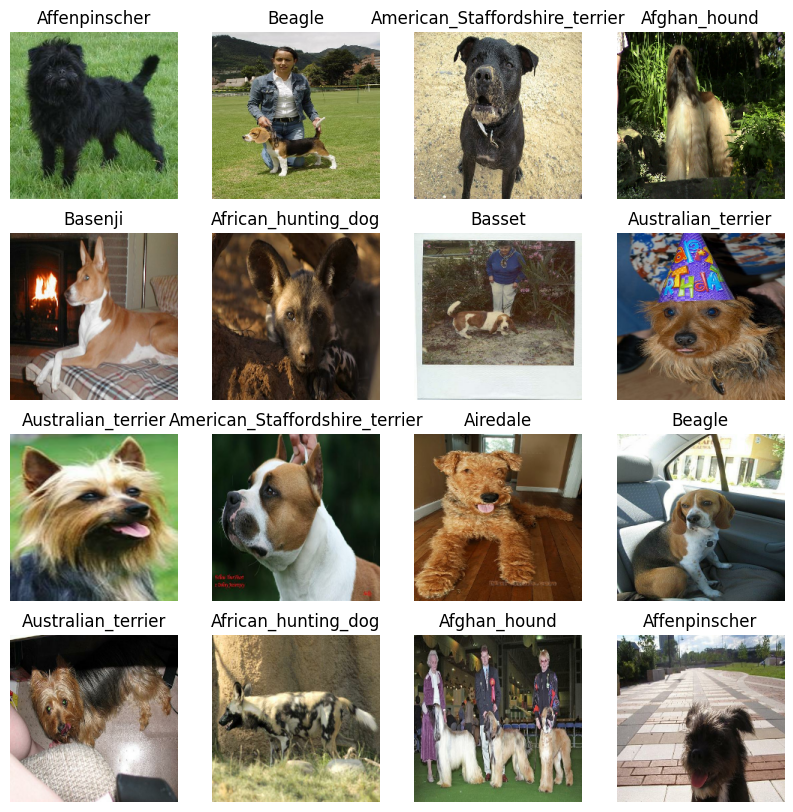

In [ ]:
# Визуализация образцов обучающей выборки
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(min(16, BATCH_SIZE)):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(keras.utils.img_to_array(images[i]).astype("uint8"))
        plt.title(CLASS_LIST[labels[i]])
        plt.axis("off")
plt.show()

## Аугментация данных

In [ ]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),  # Случайное вращение на 15%
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Случайный сдвиг на 10%
    layers.RandomFlip(),  # Случайное отражение
    layers.RandomContrast(factor=0.1),  # Случайное изменение контрастности на 10%
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

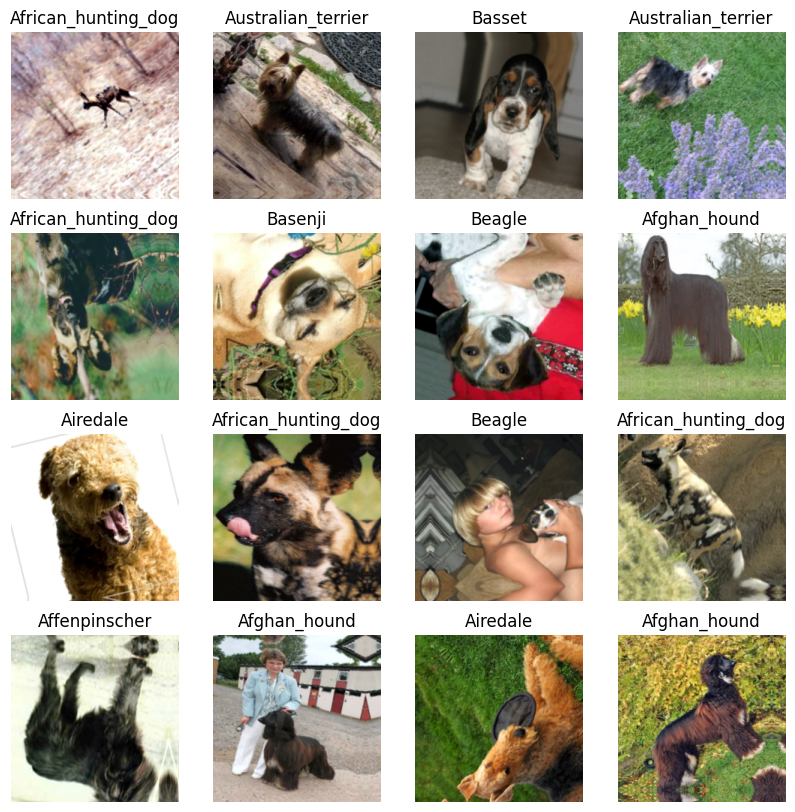

In [ ]:
# Визуализация аугментированных изображений
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(min(16, BATCH_SIZE)):
        augmented_images = img_augmentation(images[i])
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(keras.utils.img_to_array(augmented_images).astype("uint8"))
        plt.title(CLASS_LIST[labels[i]])
        plt.axis("off")
plt.show()


In [ ]:
# Применение аугментации и one-hot кодирования к выборкам
train_ds = train_ds.map(
    lambda img, label: (img_augmentation(img), keras.ops.one_hot(label, CLASS_COUNT)),
    num_parallel_calls=tf_data.AUTOTUNE,
)
val_ds = val_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, CLASS_COUNT)),
    num_parallel_calls=tf_data.AUTOTUNE,
)

# Предварительная загрузка данных для оптимизации
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

## Сборка модели

In [ ]:
# Функция для построения графиков истории обучения
def show_plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'b', label='Точность на проверочной выборке')
    plt.title('Точность на обучающей и проверочной выборках')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'b', label='Потери на проверочной выборке')
    plt.title('Потери на обучающей и проверочной выборках')
    plt.legend()
    plt.show()

# Построение модели с EfficientNetV2B0
def build_model(num_classes):
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model = EfficientNetV2B0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Заморозка предобученных весов
    model.trainable = False

    # Добавление пользовательских слоев
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Компиляция модели
    model = keras.Model(inputs, outputs, name="EfficientNetV2")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])
    return model

## Обучение модели

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 73s 955ms/step - acc: 0.6610 - loss: 1.3235 - val_acc: 0.9676 - val_loss: 0.0992
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 387ms/step - acc: 0.8406 - loss: 0.7793 - val_acc: 0.9811 - val_loss: 0.0595
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 407ms/step - acc: 0.8653 - loss: 0.7238 - val_acc: 0.9865 - val_loss: 0.0427
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 376ms/step - acc: 0.8839 - loss: 0.6085 - val_acc: 0.9757 - val_loss: 0.0640
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 393ms/step - acc: 0.8625 - loss: 0.7079 - val_acc: 0.9838 - val_loss: 0.0593
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 365ms/step - acc: 0.8952 - loss: 0.5878 - val_acc: 0.9757 - val_loss: 0.0639
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 396ms/step - acc: 0.9078 - loss: 0.4847 - val_acc: 0.9838 - val_loss: 0.0664
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - acc: 0.8871 - loss: 0.6190 - val_acc: 0.9622 - val_loss: 0.12

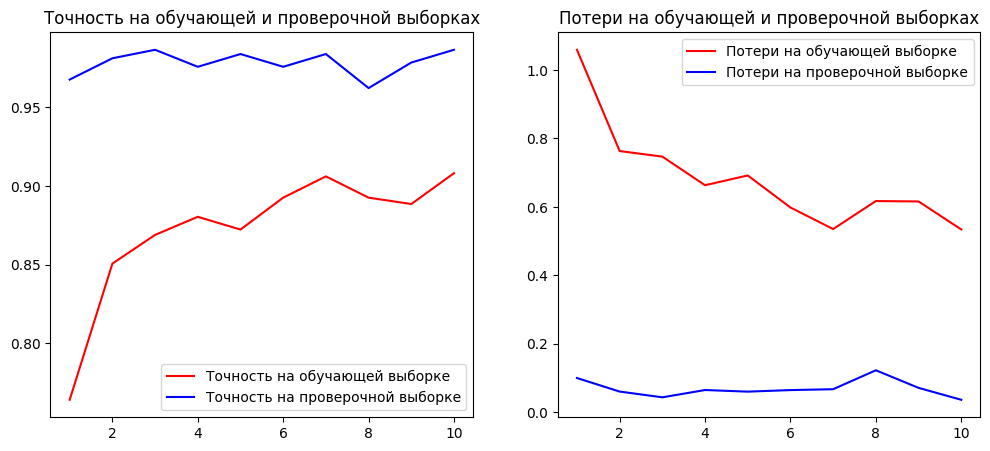

In [ ]:
# Обучение модели с замороженными слоями
epochs = 10
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model_pretrain.keras',
        monitor='val_acc',
        save_best_only=True,
        mode='max',
        verbose=0
    )
]

model = build_model(num_classes=CLASS_COUNT)
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)
show_plot(history)

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 66s 817ms/step - acc: 0.9096 - loss: 0.5641 - val_acc: 0.9865 - val_loss: 0.0373
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 398ms/step - acc: 0.9150 - loss: 0.5038 - val_acc: 0.9892 - val_loss: 0.0379
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 377ms/step - acc: 0.9148 - loss: 0.3970 - val_acc: 0.9919 - val_loss: 0.0366
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 372ms/step - acc: 0.9104 - loss: 0.4399 - val_acc: 0.9892 - val_loss: 0.0366
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 393ms/step - acc: 0.9273 - loss: 0.3949 - val_acc: 0.9892 - val_loss: 0.0373
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - acc: 0.9130 - loss: 0.4266 - val_acc: 0.9892 - val_loss: 0.0354
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 390ms/step - acc: 0.9150 - loss: 0.4736 - val_acc: 0.9892 - val_loss: 0.0338
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 442ms/step - acc: 0.9209 - loss: 0.4166 - val_acc: 0.9919 - val_loss: 0.0330
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 466ms/

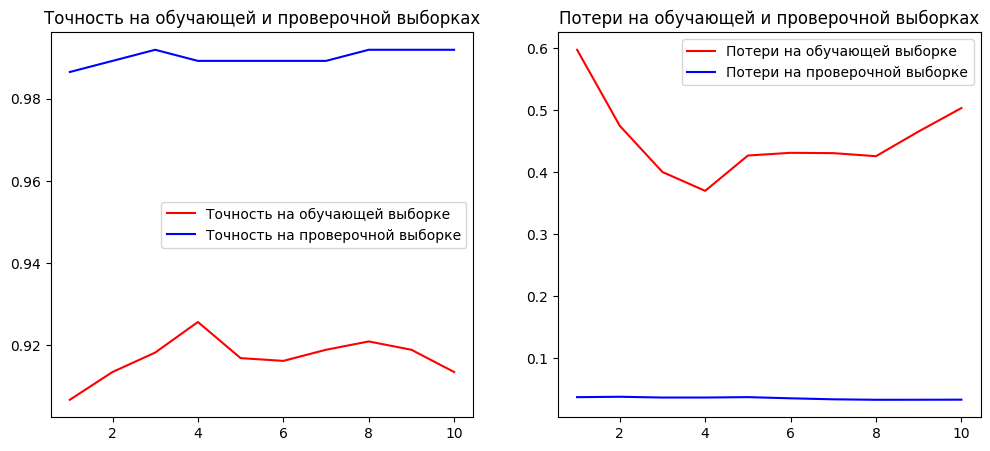

In [ ]:
# Разморозка верхних слоев для тонкой настройки
def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])

# Тонкая настройка модели
unfreeze_model(model)
epochs = 10  # Увеличенное количество эпох для тонкой настройки
history_fine = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
show_plot(history_fine)

## Оценка модели

In [ ]:
# Тестирование на выборках
print("Оценка на обучающей выборке:")
train_loss, train_acc = model.evaluate(train_ds)
print(f"Точность на обучающей выборке: {train_acc:.4f}")
print(f"Потери на обучающей выборке: {train_loss:.4f}")

print("Оценка на валидационной выборке:")
val_loss, val_acc = model.evaluate(val_ds)
print(f"Точность на валидационной выборке: {val_acc:.4f}")
print(f"Потери на валидационной выборке: {val_loss:.4f}")

Оценка на обучающей выборке:
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 432ms/step - acc: 0.9693 - loss: 0.1755
Точность на обучающей выборке: 0.9655
Потери на обучающей выборке: 0.1671
Оценка на валидационной выборке:
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - acc: 0.9899 - loss: 0.0431
Точность на валидационной выборке: 0.9919
Потери на валидационной выборке: 0.0332


In [ ]:
# Для сохранение модели до отключения сеанса Colab
model.save('./dogs_classification_fine_tune.keras')

## Проверка сохраненной предобученной модели

In [ ]:
# Скачивание ранее предобученной модели
!wget https://storage.yandexcloud.net/bot-baket-quiz/dogs_classification_fine_tune.keras

--2025-05-16 12:11:34--  https://storage.yandexcloud.net/bot-baket-quiz/best_model_pretrain_fine_tuned.keras
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24831461 (24M) [application/x-www-form-urlencoded]
Saving to: ‘best_model_pretrain_fine_tuned.keras’

best_model_pretrain 100%[===================>]  23.68M  9.47MB/s    in 2.5s    

2025-05-16 12:11:37 (9.47 MB/s) - ‘best_model_pretrain_fine_tuned.keras’ saved [24831461/24831461]



In [ ]:
## Загрузка предобученной модели
from tensorflow.keras.models import load_model
model = load_model('./best_model_pretrain_fine_tuned.keras')

--2025-05-16 13:50:07--  https://i.pinimg.com/736x/53/b2/19/53b219ed82210b4741fe252bf99a2e89.jpg
Resolving i.pinimg.com (i.pinimg.com)... 104.97.85.182, 104.97.85.151, 104.97.85.150, ...
Connecting to i.pinimg.com (i.pinimg.com)|104.97.85.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75525 (74K) [image/jpeg]
Saving to: ‘53b219ed82210b4741fe252bf99a2e89.jpg’

53b219ed82210b4741f 100%[===================>]  73.75K  --.-KB/s    in 0.04s   

2025-05-16 13:50:07 (1.96 MB/s) - ‘53b219ed82210b4741fe252bf99a2e89.jpg’ saved [75525/75525]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


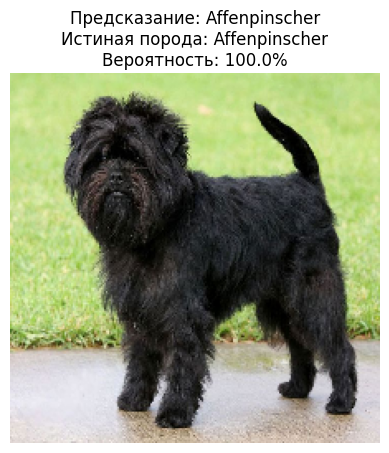

In [ ]:
# Тестирование модели на примере изображения
!wget https://i.pinimg.com/736x/53/b2/19/53b219ed82210b4741fe252bf99a2e89.jpg
TEST_IMG = './53b219ed82210b4741fe252bf99a2e89.jpg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
plt.imshow(img)
img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)

predictions = model.predict(img_array)
predicted_class = CLASS_LIST[keras.ops.argmax(predictions)]
confidence = keras.ops.max(predictions) * 100

plt.title(f"Предсказание: {predicted_class}\nИстиная порода: Affenpinscher\nВероятность: {confidence:.1f}%")
plt.axis("off")
plt.show()



---



## Вывод

В этом проекте я создал классификатор пород собак на основе предобученной модели EfficientNetV2B0 из Keras, используя transfer learning для адаптации к датасету Stanford Dogs, где выбрал 10 случайных пород для упрощения задачи. Я подготовил данные: загрузил датасет, очистил поврежденные изображения, разделил на обучающую и валидационную выборки с помощью, и применил аугментацию (вращение, сдвиг, отражение, контраст) для повышения обобщающей способности модели. Модель собрал с замороженными весами базовой сети, добавил глобальный pooling, dropout и полносвязный слой для классификации, скомпилировал с Adam и categorical_crossentropy, и обучил на 10 эпохах, сохраняя лучшую версию по параметру val_acc. Затем провел fine-tuning, разморозив последние 20 слоев и снизив learning rate до 1e-5, что позволило улучшить точность за счет адаптации под данные.

Оценил модель на train и val выборках, получив хорошие метрики (точность 0.9+), и протестировал на отдельном изображении, подтвердив работоспособность.

Научился эффективно использовать transfer learning для задач компьютерного зрения с ограниченными данными, избегая переобучения через аугментацию и поэтапное обучение. Также понял важность предобработки изображений и мониторинга графиков loss/acc для анализа динамики обучения. В итоге, проект показал, что EfficientNetV2 хорошо подходит для классификации изображений, но требует осторожного тюнинга гиперпараметров для баланса между скоростью и точностью.